### Importing Packages

In [1]:
import os
import scipy
from scipy.ndimage import zoom
import nibabel as nib
from nilearn import plotting
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.losses import CategoricalCrossentropy,MeanSquaredError
from tensorflow.keras.losses import SparseCategoricalCrossentropy as SparseCategoricalCrossentropyV1
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import Accuracy,CategoricalAccuracy,SparseCategoricalAccuracy
from tensorflow.keras.models import Model,Sequential
import tensorflow.keras.backend as K
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.callbacks import History, EarlyStopping
import seaborn as sns

In [2]:
folder_path = 'D:\Tehila_Ran_Data\ADNI2PRECN\ADNI'
CN_fmri = []
labels_CN = []
cnt=0
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii') and cnt<1000:  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            img_data = img.get_fdata()

            
            CN_fmri.append(img_data)
            labels_CN.append(0)
            cnt+=1

In [3]:
folder_path = 'D:\Tehila_Ran_Data\ADNI2PREMCI\ADNI'
MCI_fmri = []
labels_MCI = []
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii'):  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            img_data = img.get_fdata()
            

            MCI_fmri.append(img_data)
            labels_MCI.append(1)

In [4]:
folder_path = 'D:\Tehila_Ran_Data\ADNI2PREAD\ADNI'
AD_fmri = []
labels_AD = []
cnt=0
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith('.nii') and cnt<1000:  
            image_path = os.path.join(root, filename)
            img = nib.load(image_path)
            img_data = img.get_fdata()
            
            
            AD_fmri.append(img_data)
            labels_AD.append(2)
            cnt+=1

### Preprocessing for fitting the 3D CNN model

In [5]:
for i, arr in enumerate(CN_fmri[:200]):
    print(f"CN_fmri[{i}] shape:", np.array(arr).shape)

CN_fmri[0] shape: (170, 256, 256)
CN_fmri[1] shape: (170, 256, 256)
CN_fmri[2] shape: (170, 256, 256)
CN_fmri[3] shape: (170, 256, 256)
CN_fmri[4] shape: (170, 256, 256)
CN_fmri[5] shape: (170, 256, 256)
CN_fmri[6] shape: (170, 256, 256)
CN_fmri[7] shape: (170, 256, 256)
CN_fmri[8] shape: (170, 256, 256)
CN_fmri[9] shape: (170, 256, 256)
CN_fmri[10] shape: (170, 256, 256)
CN_fmri[11] shape: (170, 256, 256)
CN_fmri[12] shape: (170, 256, 256)
CN_fmri[13] shape: (170, 256, 256)
CN_fmri[14] shape: (170, 256, 256)
CN_fmri[15] shape: (170, 256, 256)
CN_fmri[16] shape: (170, 256, 256)
CN_fmri[17] shape: (170, 256, 256)
CN_fmri[18] shape: (170, 256, 256)
CN_fmri[19] shape: (170, 256, 256)
CN_fmri[20] shape: (170, 256, 256)
CN_fmri[21] shape: (170, 256, 256)
CN_fmri[22] shape: (170, 256, 256)
CN_fmri[23] shape: (170, 256, 256)
CN_fmri[24] shape: (170, 256, 256)
CN_fmri[25] shape: (170, 256, 256)
CN_fmri[26] shape: (170, 256, 256)
CN_fmri[27] shape: (170, 256, 256)
CN_fmri[28] shape: (170, 256, 

In [5]:
target_shape = (90,108,108)  # Specify your desired shape here

# Initialize lists to store resized images
resized_CN_fmri = []
resized_MCI_fmri = []
resized_AD_fmri = []

# Resize images in CN_fmri
for img in CN_fmri:
    resized_img = zoom(img, target_shape / np.array(img.shape), order=1)
    resized_CN_fmri.append(resized_img)

CN_fmri = 0
# Resize images in MCI_fmri
for img in MCI_fmri:
    resized_img = zoom(img, target_shape / np.array(img.shape), order=1)
    resized_MCI_fmri.append(resized_img)

MCI_fmri = 0
# Resize images in AD_fmri
for img in AD_fmri:
    resized_img = zoom(img, target_shape / np.array(img.shape), order=1)
    resized_AD_fmri.append(resized_img)

AD_fmri = 0

In [6]:
features = np.concatenate((np.array(resized_CN_fmri),np.array(resized_MCI_fmri),np.array(resized_AD_fmri)), axis=0)

In [7]:
labels = np.concatenate((labels_CN,labels_MCI,labels_AD), axis=0)

In [8]:
x_size, y_size, z_size= features[200].shape
features[200].shape

(90, 108, 108)

In [9]:
x_train, x_te, y_train, y_te = train_test_split(features,labels,test_size=0.3,stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_te,y_te,test_size=0.5,stratify=y_te)


## The model - 3D convolutional neural network

### No dropout

In [17]:
model = models.Sequential()

# Convolutional layers
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(x_size, y_size, z_size,1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, kernel_size=(2, 2, 2), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))


model.add(Flatten())

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 88, 106, 106, 64   1792      
                             )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 44, 53, 53, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 43, 52, 52, 32)    16416     
                                                                 
 max_pooling3d_5 (MaxPoolin  (None, 21, 26, 26, 32)    0         
 g3D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 454272)            0         
                                                      

In [19]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/200
58/58 [==============================] - 597s 10s/step - loss: 1459.9156 - accuracy: 0.4340 - val_loss: 0.9678 - val_accuracy: 0.4731
Epoch 2/200
58/58 [==============================] - 589s 10s/step - loss: 0.9097 - accuracy: 0.5380 - val_loss: 0.9267 - val_accuracy: 0.4808
Epoch 3/200
58/58 [==============================] - 583s 10s/step - loss: 0.7445 - accuracy: 0.6645 - val_loss: 0.9267 - val_accuracy: 0.5371
Epoch 4/200
58/58 [==============================] - 584s 10s/step - loss: 0.5868 - accuracy: 0.7701 - val_loss: 1.0190 - val_accuracy: 0.6138
Epoch 5/200
58/58 [==============================] - 590s 10s/step - loss: 0.4162 - accuracy: 0.8506 - val_loss: 1.0453 - val_accuracy: 0.6240
Epoch 6/200
58/58 [==============================] - 585s 10s/step - loss: 0.2727 - accuracy: 0.9130 - val_loss: 1.1990 - val_accuracy: 0.6598
Epoch 7/200
58/58 [==============================] - 583s 10s/step - loss: 0.1726 - accuracy: 0.9502 - val_loss: 1.4373 - val_accuracy: 0.6

13/13 [==============================] - 16s 1s/step


<Axes: >

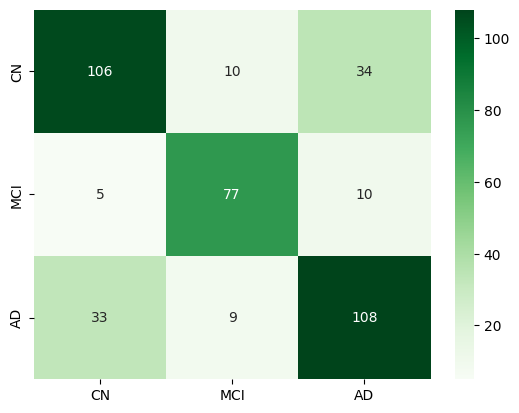

In [20]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

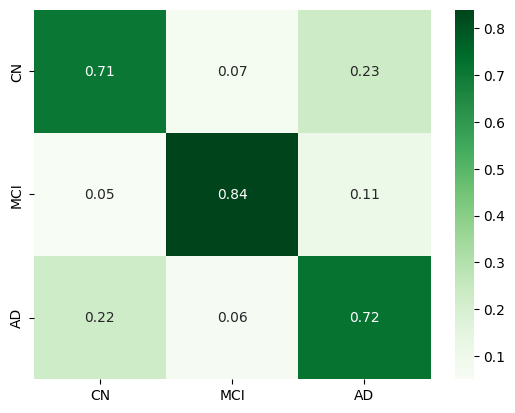

In [21]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

13/13 [==============================] - 16s 1s/step


<Axes: >

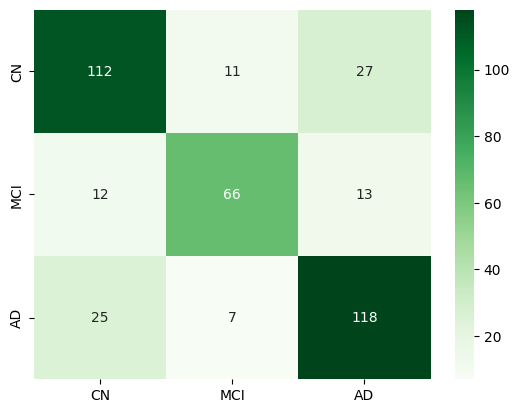

In [22]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

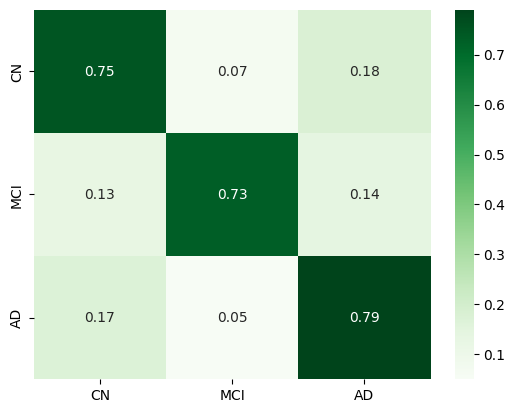

In [23]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

In [24]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<10:
    epochs_applied=200

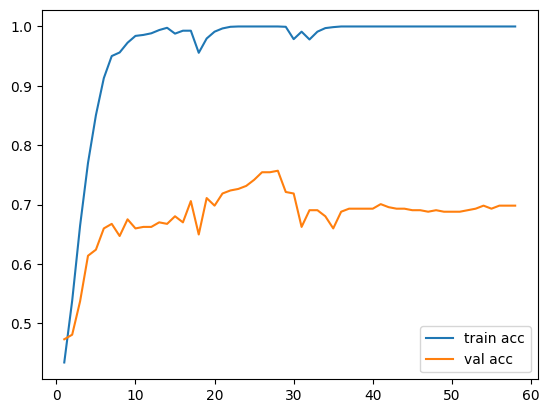

In [25]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
#plt.plot(lenx, test_acc_values, label = "test acc")
plt.legend()
plt.show()

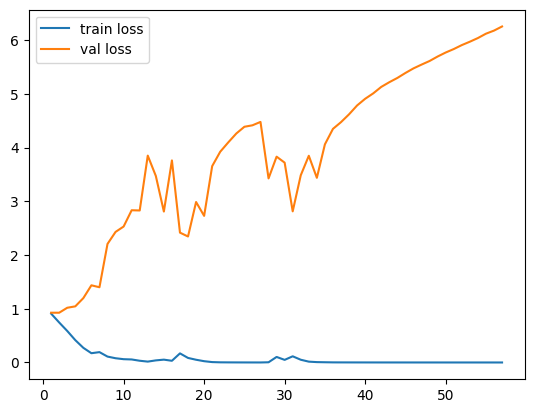

In [26]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
#plt.plot(lenx, test_loss_values, label = "test loss")
plt.legend()
plt.show()

In [34]:
K.clear_session()

### Dropout

In [39]:
model = models.Sequential()

# Convolutional layers
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', input_shape=(x_size, y_size, z_size,1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### Confusion matrixes and results

In [40]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/200
58/58 [==============================] - 435s 8s/step - loss: 1635.1331 - accuracy: 0.4012 - val_loss: 1.0767 - val_accuracy: 0.3248
Epoch 2/200
58/58 [==============================] - 426s 7s/step - loss: 1.1313 - accuracy: 0.3946 - val_loss: 1.0818 - val_accuracy: 0.3453
Epoch 3/200
58/58 [==============================] - 425s 7s/step - loss: 1.0814 - accuracy: 0.3870 - val_loss: 1.0811 - val_accuracy: 0.3683
Epoch 4/200
58/58 [==============================] - 429s 7s/step - loss: 1.0413 - accuracy: 0.4072 - val_loss: 1.0596 - val_accuracy: 0.3734
Epoch 5/200
58/58 [==============================] - 426s 7s/step - loss: 0.9967 - accuracy: 0.4132 - val_loss: 1.0452 - val_accuracy: 0.3964
Epoch 6/200
58/58 [==============================] - 431s 7s/step - loss: 1.0011 - accuracy: 0.4351 - val_loss: 1.0430 - val_accuracy: 0.4501
Epoch 7/200
58/58 [==============================] - 428s 7s/step - loss: 0.9680 - accuracy: 0.4532 - val_loss: 1.0282 - val_accuracy: 0.4399
Epo

13/13 [==============================] - 19s 1s/step


<Axes: >

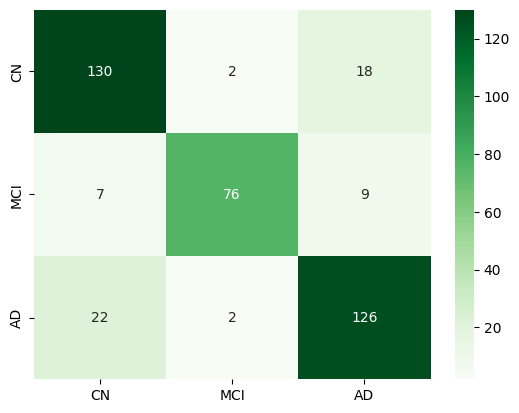

In [54]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

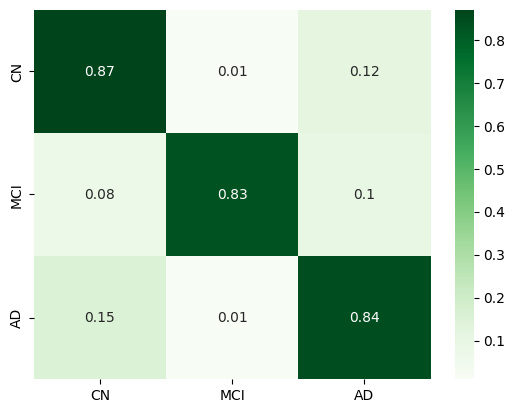

In [55]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

13/13 [==============================] - 21s 2s/step


<Axes: >

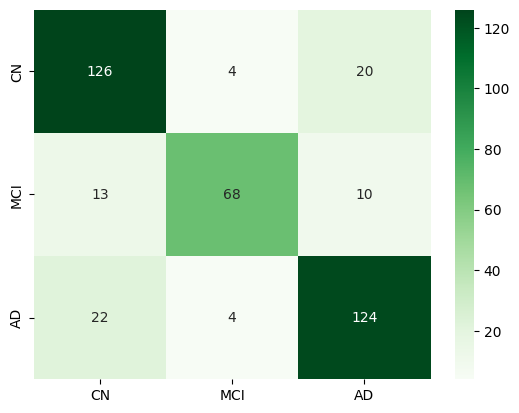

In [56]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

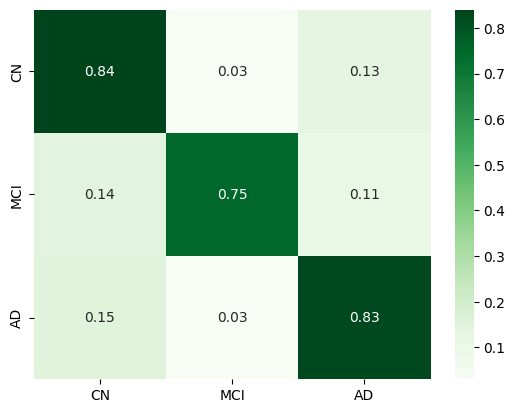

In [57]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

In [58]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<10:
    epochs_applied=200

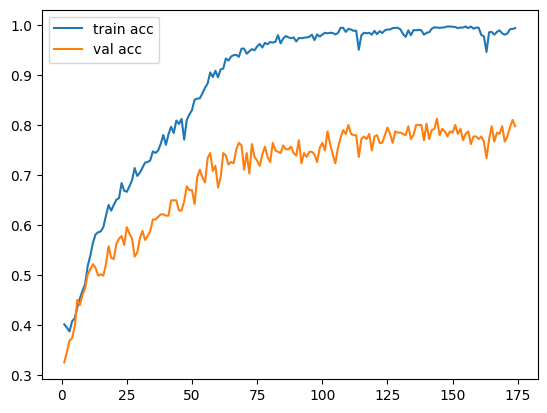

In [59]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

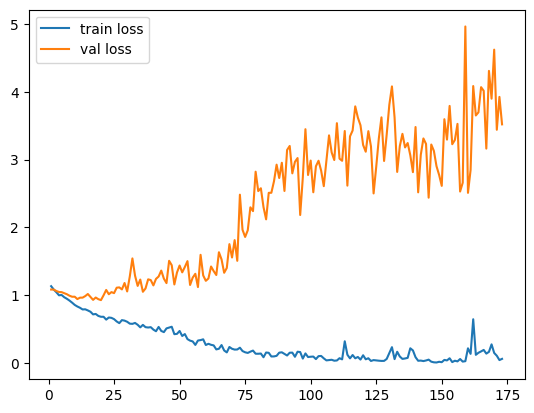

In [60]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
#plt.plot(lenx, test_loss_values, label = "test loss")
plt.legend()
plt.show()

In [63]:
selected_img = 0
for i in range(len(y_train)):
    if y_train[i]==0:
        selected_img = x_train[i]
        break

In [50]:
selected_img = 0
for i in range(len(y_test)):
    if y_test[i]==1:
        selected_img = x_test[i]
        break

In [46]:
selected_img = 0
for i in range(len(labels)):
    if labels[i]==2:
        selected_img = features[i]
        break

In [119]:
K.clear_session()

## Vistransformer

In [143]:
slice_index = 54  # Choose the index of the slice you want to extract

# Convert 3D images to 2D (single slice)
CN_fmri_2d = [pic[:, :, slice_index] for pic in resized_CN_fmri]
MCI_fmri_2d = [pic[:, :, slice_index] for pic in resized_MCI_fmri]
AD_fmri_2d = [pic[:, :, slice_index] for pic in resized_AD_fmri]

# Combine all 2D slices into a single numpy array
CN_fmri_2d = np.array(CN_fmri_2d)
MCI_fmri_2d = np.array(MCI_fmri_2d)
AD_fmri_2d = np.array(AD_fmri_2d)

# Reshape the data to have a single channel (as it's grayscale)
CN_fmri_2d = CN_fmri_2d[..., np.newaxis]
MCI_fmri_2d = MCI_fmri_2d[..., np.newaxis]
AD_fmri_2d = AD_fmri_2d[..., np.newaxis]

In [144]:
features_2d = np.concatenate((CN_fmri_2d, MCI_fmri_2d, AD_fmri_2d), axis=0)

In [120]:
x_train, x_te, y_train, y_te = train_test_split(features_2d,labels,test_size=0.3,stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_te,y_te,test_size=0.5,stratify=y_te)

In [96]:
input_shape = CN_fmri_2d.shape[1:]  # Input shape is determined by the shape of the 2D slice
num_classes = 3  # Number of output classes

In [145]:
inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)

embedding_dim = 64  # Embedding dimension
num_heads = 2  # Number of attention heads
transformer_units = [(embedding_dim * 2), (embedding_dim)]  # Feedforward network units
num_transformer_blocks = 2  # Adjust as needed

for _ in range(num_transformer_blocks):
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x, x)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output + x)

    # Feedforward network
    feedforward_output = layers.Conv2D(transformer_units[0], kernel_size=1, activation="relu")(attention_output)
    feedforward_output = layers.Conv2D(transformer_units[1], kernel_size=1)(feedforward_output)
    x = layers.LayerNormalization(epsilon=1e-6)(attention_output + feedforward_output)

x = layers.GlobalMaxPooling2D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [146]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 90, 108, 1)]         0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 45, 54, 64)           640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 45, 54, 64)           256       ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 45, 54, 64)           33216     ['batch_normalization[0]

In [147]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/200
58/58 [==============================] - 320s 5s/step - loss: 1.1186 - accuracy: 0.4822 - val_loss: 0.9821 - val_accuracy: 0.5090
Epoch 2/200
58/58 [==============================] - 316s 5s/step - loss: 0.8722 - accuracy: 0.5769 - val_loss: 0.9615 - val_accuracy: 0.5371
Epoch 3/200
58/58 [==============================] - 314s 5s/step - loss: 0.8360 - accuracy: 0.5955 - val_loss: 0.9516 - val_accuracy: 0.5217
Epoch 4/200
58/58 [==============================] - 314s 5s/step - loss: 0.8008 - accuracy: 0.6103 - val_loss: 0.8672 - val_accuracy: 0.6138
Epoch 5/200
58/58 [==============================] - 313s 5s/step - loss: 0.7640 - accuracy: 0.6355 - val_loss: 0.9034 - val_accuracy: 0.5754
Epoch 6/200
58/58 [==============================] - 314s 5s/step - loss: 0.7719 - accuracy: 0.6344 - val_loss: 0.9296 - val_accuracy: 0.5575
Epoch 7/200
58/58 [==============================] - 314s 5s/step - loss: 0.7903 - accuracy: 0.6169 - val_loss: 0.8598 - val_accuracy: 0.6113
Epoch 

13/13 [==============================] - 30s 2s/step


<Axes: >

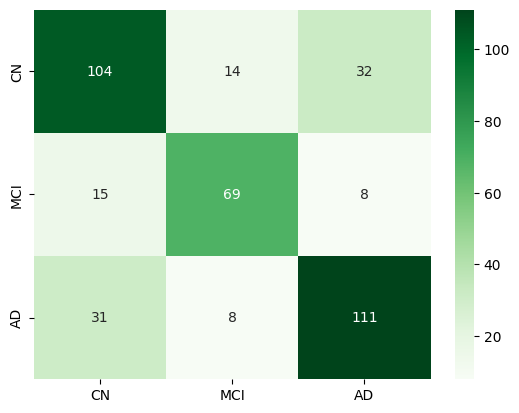

In [157]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

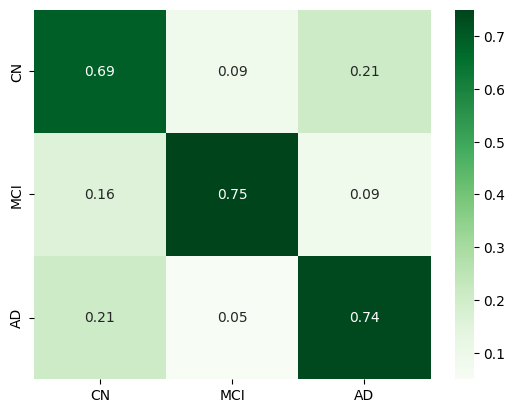

In [158]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

13/13 [==============================] - 30s 2s/step


<Axes: >

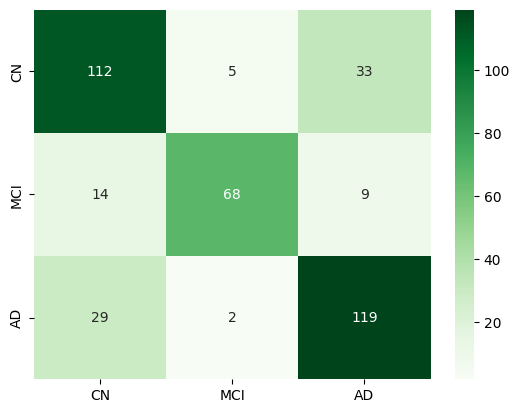

In [159]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

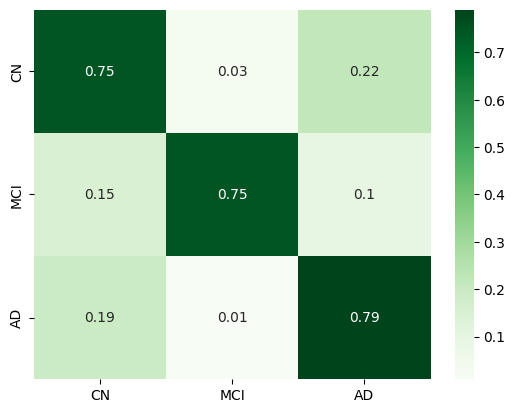

In [160]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

In [161]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<10:
    epochs_applied=100

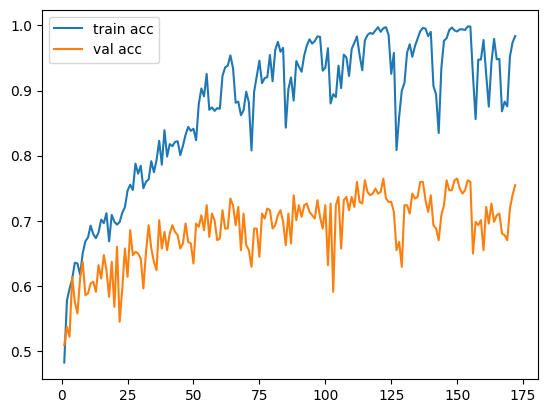

In [162]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

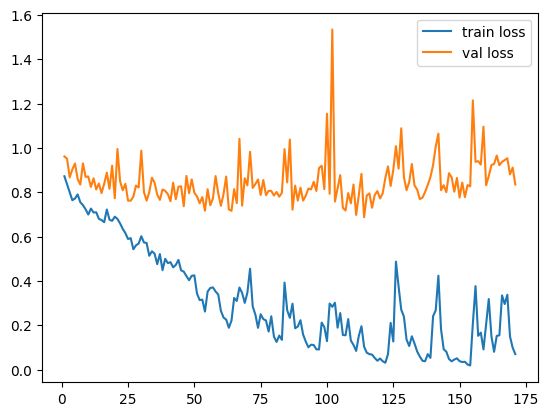

In [163]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
plt.legend()
plt.show()

In [164]:
K.clear_session()

### CNN 2D

In [165]:
inputs = keras.Input(shape=input_shape)

# Convolutional layers for local feature extraction
x = layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
x = layers.GlobalMaxPooling2D()(x)
x = layers.Dense(128, activation='relu')(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [166]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 108, 1)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 54, 32)        320       
                                                                 
 global_max_pooling2d_1 (Gl  (None, 32)                0         
 obalMaxPooling2D)                                               
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 4931 (19.26 KB)
Trainable params: 4931 (19.26 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________

In [167]:
history_callback = History()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=300, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=2000, validation_data=(x_val, y_val),callbacks=[history_callback, early_stopping])
train_loss_values = history.history['loss']
train_acc_values = history.history['accuracy']
val_loss_values = history.history['val_loss']
val_acc_values = history.history['val_accuracy']


# Evaluate the model on the test set
val_loss, val_accuracy =  model.evaluate(x_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/2000
58/58 [==============================] - 1s 9ms/step - loss: 28.8191 - accuracy: 0.3864 - val_loss: 14.2486 - val_accuracy: 0.3862
Epoch 2/2000
58/58 [==============================] - 0s 6ms/step - loss: 12.8812 - accuracy: 0.3941 - val_loss: 14.4405 - val_accuracy: 0.4143
Epoch 3/2000
58/58 [==============================] - 0s 6ms/step - loss: 16.1285 - accuracy: 0.4165 - val_loss: 11.1587 - val_accuracy: 0.4297
Epoch 4/2000
58/58 [==============================] - 0s 6ms/step - loss: 10.2101 - accuracy: 0.4182 - val_loss: 8.7147 - val_accuracy: 0.4450
Epoch 5/2000
58/58 [==============================] - 0s 6ms/step - loss: 8.3562 - accuracy: 0.4406 - val_loss: 7.8624 - val_accuracy: 0.4731
Epoch 6/2000
58/58 [==============================] - 0s 7ms/step - loss: 6.3927 - accuracy: 0.4603 - val_loss: 14.5147 - val_accuracy: 0.4322
Epoch 7/2000
58/58 [==============================] - 0s 7ms/step - loss: 6.8797 - accuracy: 0.4368 - val_loss: 10.9104 - val_accuracy: 0.44

13/13 [==============================] - 0s 2ms/step


<Axes: >

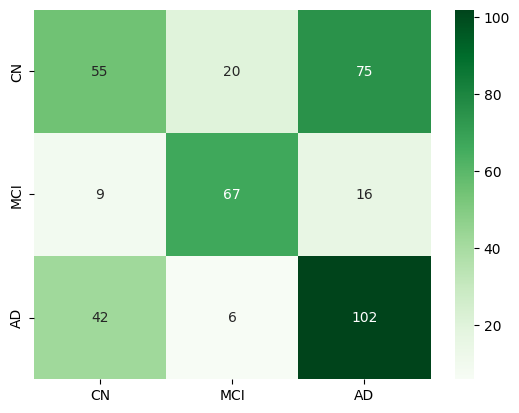

In [168]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_test, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

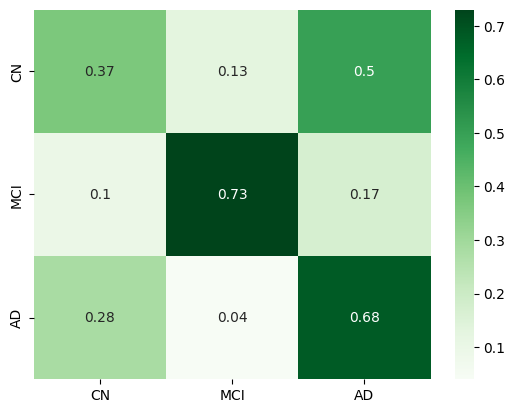

In [169]:
mat = confusion_matrix(y_test, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

13/13 [==============================] - 0s 2ms/step


<Axes: >

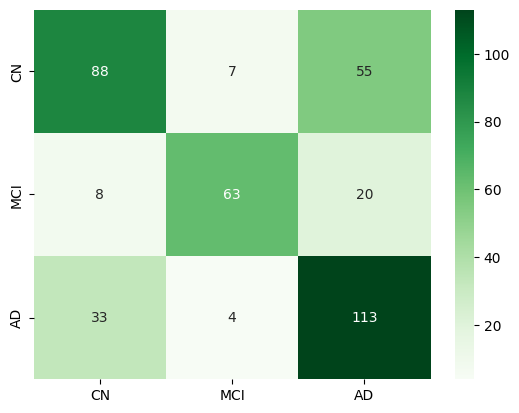

In [170]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis=1)
df = pd.DataFrame(data = confusion_matrix(y_val, predictions),
  columns = ['CN','MCI', 'AD'],
  index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True, fmt='.0f')

<Axes: >

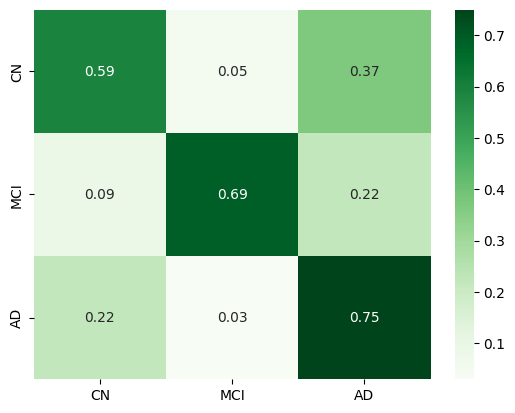

In [171]:
mat = confusion_matrix(y_val, predictions)
df =pd.DataFrame((mat/mat.sum(axis = 1,keepdims = True)).round(2), columns = ['CN','MCI', 'AD'],index = ['CN','MCI', 'AD'])
sns.heatmap(df, cmap="Greens", annot=True)

In [172]:
epochs_applied = early_stopping.stopped_epoch + 1
if epochs_applied<100:
    epochs_applied=2000

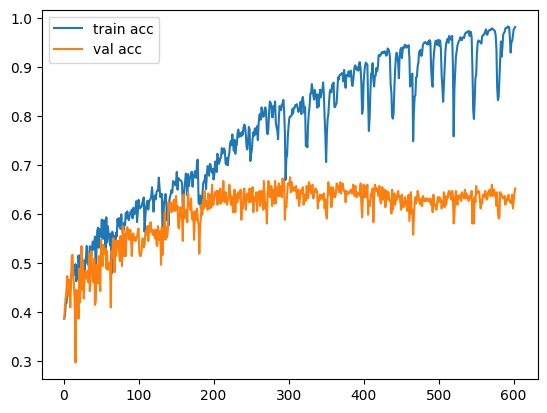

In [173]:
lenx = [i+1 for i in range(epochs_applied)]
plt.plot(lenx, train_acc_values, label = "train acc")
plt.plot(lenx, val_acc_values, label = "val acc")
plt.legend()
plt.show()

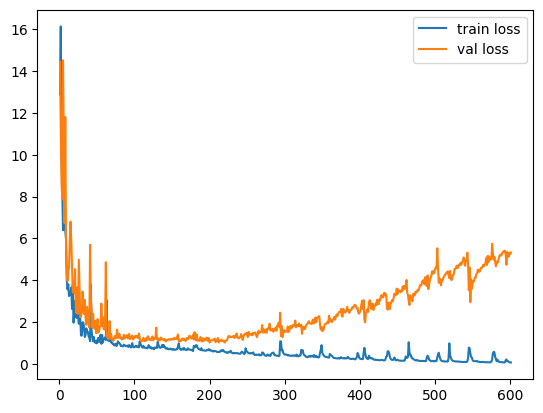

In [174]:
lenx = [i+1 for i in range(epochs_applied-1)]
plt.plot(lenx, train_loss_values[1:],label = "train loss")
plt.plot(lenx, val_loss_values[1:], label = "val loss")
plt.legend()
plt.show()